In [279]:
import torch

import matplotlib.pyplot as plt

from typing import Any

Text(0.5, 1.0, 'Data')

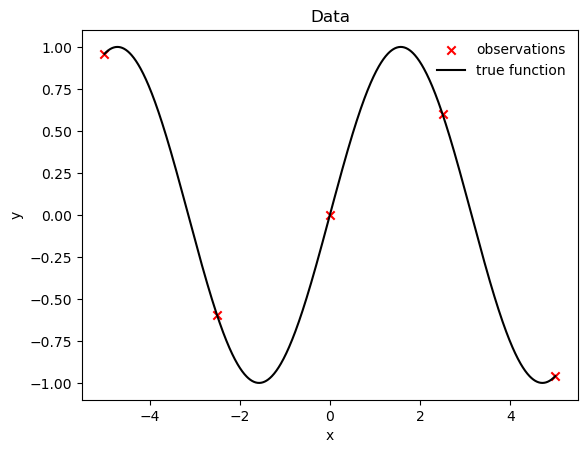

In [36]:
# make some data
x_train = torch.linspace(-5, 5, 5)
y_train = torch.sin(x_train)

# plot the data
plt.scatter(x_train, y_train, marker = 'x', color = 'red', label = 'observations')
plt.plot(torch.linspace(-5, 5, 1000), torch.sin(torch.linspace(-5, 5, 1000)), color = 'black', label = 'true function')

# plot style
plt.legend(frameon = False)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data')

In [263]:
# imports
from VFF.kernels import matern_12
from VFF.basis import FourierBasis
from VFF.covariances import matern_12_Kuf, matern_12_Kuu

import torch.distributions as dist

In [278]:
class VaritionalGaussianDistribution:

    """ variational Gaussian distribution for Variational Fourier Features """

    def __init__(self, Kuu : torch.Tensor, Kuf : torch.Tensor, sigma : float):
        """ 
        Arguments:
            Kuu (torch.Tensor)      : Kuu
            Kuf (torch.Tensor)      : Kuf
            sigma (float)           : amplitude hyperparameter 
        """
        self.Kuu = Kuu
        self.Kuf = Kuf
        self.sigma = sigma
        # mean and covariance
        self.variational_sigma = self._variational_cov()
        self.variational_mean = self._vartional_mu()
    

    def _variational_cov(self,):
        """ Computes the covariance for the optimal Gaussian Distribution """
        # compute variational sigma
        Kuu_inv = torch.inverse(self.Kuu)
        variational_precision = Kuu_inv + (1 / self.sigma ** 2) * Kuu_inv @ self.Kuf.T @ self.Kuf @ Kuu_inv
        variational_sigma = torch.inverse(variational_precision)

        return variational_sigma
    

    def _vartional_mu(self,):
        """ Computes the mean for the optimal Gaussian Distribution """
        # compute variational mu   
        variational_mean = (1 / (self.sigma ** 2)) * self.variational_sigma @ self.Kuf.T @ y_train
        
        return variational_mean

In [399]:
class VFF:

    """ Constructs a Vartional Fourier Features Gasussian Process Regression model """

    def __init__( self, xtrain : torch.Tensor, ytrain : torch.Tensor, M : int, a : float, b : float, sigma : float, lengthscale : float,) -> 'VFF':
        """
        Arguments:
            xtrain (torch.Tensor)   : training inputs
            ytrain (torch.Tensor)   : training outputs
            M (int)                 : number of frequencies
            a (float)               : lower bound of the input space
            b (float)               : upper bound of the input space
            sigma (float)           : amplitude hyperparameter
            lengthscale (float)     : lengthscale hyperparameter

        Returns:
            (VFF)                   : VFF model
        """
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.M = M
        self.a = a
        self.b = b
        self.sigma = torch.nn.Parameter(torch.tensor(sigma))
        self.lengthscale = torch.nn.Parameter(torch.tensor(lengthscale))
        self.basis = FourierBasis(M, a, b)
        self.Kff = matern_12(tau = torch.cdist(xtrain.unsqueeze(-1), xtrain.unsqueeze(-1)), sigma = sigma, lengthscale = lengthscale)
        self.Kuf = matern_12_Kuf(self.basis, xtrain)
        self.Kuu = matern_12_Kuu(self.basis.omegas, sigma, lengthscale, a, b)
        self.varitional_distribution = VaritionalGaussianDistribution(self.Kuu, self.Kuf, sigma)


    def _elbow(self,):
        """ Computes the elbow for the optimal variational gaussian distribution """

        # compute matrices
        Kff = matern_12(tau = torch.cdist(self.xtrain.unsqueeze(-1), self.xtrain.unsqueeze(-1)), sigma = self.sigma, lengthscale = self.lengthscale)
        Kuf = matern_12_Kuf(self.basis, self.xtrain)
        Kuu = matern_12_Kuu(self.basis.omegas, self.sigma, self.lengthscale, self.a, self.b)

        # compute the KfuKUUinvKuf term
        approximate_prior = Kuf @ torch.inverse(Kuu) @ Kuf.T

        # log probability term
        mean = torch.zeros(len(self.xtrain))
        covariance = approximate_prior+ (self.sigma ** 2) * torch.eye(len(self.xtrain))
        log_prob_term = dist.MultivariateNormal(mean, covariance).log_prob(y_train) 

        # trace term
        trace_term = - (1 / 2) * (1 / self.sigma ** 2) * torch.trace(Kff - approximate_prior)

        # compute the elbow
        elbow = log_prob_term + trace_term

        return elbow
    

    def fit(self, learningrate : float, numberofiterations : int):
        """ Fits the hyperparameters of the model """

        # optimizer
        optimizer = torch.optim.Adam([self.sigma, self.lengthscale], lr = learningrate)

        # fit the model
        for i in range(numberofiterations):
            optimizer.zero_grad()
            elbow = -self._elbow()
            elbow.backward()
            optimizer.step()
            print(f'Iteration {i + 1} / {numberofiterations} : Elbow {elbow.item()}')

        # updated the variational distribution
        Kuf = matern_12_Kuf(self.basis, self.xtrain)
        Kuu = matern_12_Kuu(self.basis.omegas, self.sigma, self.lengthscale, self.a, self.b)
        self.varitional_distribution = VaritionalGaussianDistribution(self.Kuu, self.Kuf, self.sigma)

    
    def predict( self, xtest : torch.Tensor ) -> dist.MultivariateNormal:
        """
        Computes the predictive distribution for given test points

        Arguments:
            xtest (torch.Tensor)    : test points

        Returns:
            (dist.MultivariateNormal) : predictive distribution
        """

        # get variational mean and covariance
        variational_mu = self.varitional_distribution.variational_mean
        variational_sigma = self.varitional_distribution.variational_sigma

        # test point pairwise distances
        tau_test = torch.cdist(xtest.unsqueeze(-1), xtest.unsqueeze(-1))

        # compute test matrices
        Kuu_inv = torch.inverse(self.Kuu)
        Kxx = matern_12(tau = tau_test, sigma = self.sigma, lengthscale = self.lengthscale)
        Kuf_test = matern_12_Kuf(self.basis, xtest)
        
        # compute predictive mean and covariance
        gp_mean = (Kuf_test @ Kuu_inv) @ variational_mu
        gp_covariance = Kxx + (Kuf_test @ (Kuu_inv @ variational_sigma @ Kuu_inv - Kuu_inv) @ Kuf_test.T)


        # enforce PSD
        eigenvalues, eigenvectors = torch.linalg.eigh(gp_covariance)
        eigenvalues = torch.max(eigenvalues, torch.tensor(1e-8))  # Set negative eigenvalues to epsilon
        gp_covariance = eigenvectors @ torch.diag(eigenvalues) @ eigenvectors.t()

        return dist.MultivariateNormal(gp_mean.detach(), gp_covariance.detach())

In [422]:
# define the hyperparemeters
SIGMA = 1.0
LENGTHSCALE = 1.0
A_LIM = -5.0
B_LIM = 5.0
M = 1

In [423]:
vff_model = VFF(x_train, y_train, M = M, a = A_LIM, b = B_LIM, sigma = SIGMA, lengthscale = LENGTHSCALE)

In [424]:
vff_model.fit(learningrate = 0.01, numberofiterations = 100)

Iteration 1 / 100 : Elbow 8.04334545135498
Iteration 2 / 100 : Elbow 8.012340545654297
Iteration 3 / 100 : Elbow 7.981472969055176
Iteration 4 / 100 : Elbow 7.9507622718811035
Iteration 5 / 100 : Elbow 7.920230388641357
Iteration 6 / 100 : Elbow 7.8899006843566895
Iteration 7 / 100 : Elbow 7.859800338745117
Iteration 8 / 100 : Elbow 7.829957485198975
Iteration 9 / 100 : Elbow 7.800400257110596
Iteration 10 / 100 : Elbow 7.771162509918213
Iteration 11 / 100 : Elbow 7.7422776222229
Iteration 12 / 100 : Elbow 7.7137837409973145
Iteration 13 / 100 : Elbow 7.685720443725586
Iteration 14 / 100 : Elbow 7.658130168914795
Iteration 15 / 100 : Elbow 7.6310553550720215
Iteration 16 / 100 : Elbow 7.604543685913086
Iteration 17 / 100 : Elbow 7.5786452293396
Iteration 18 / 100 : Elbow 7.55341100692749
Iteration 19 / 100 : Elbow 7.528891563415527
Iteration 20 / 100 : Elbow 7.505145072937012
Iteration 21 / 100 : Elbow 7.482224464416504
Iteration 22 / 100 : Elbow 7.460186958312988
Iteration 23 / 100 : 

In [425]:
vff_model.sigma

Parameter containing:
tensor(0.6632, requires_grad=True)

In [426]:
vff_model.lengthscale

Parameter containing:
tensor(1.9529, requires_grad=True)

In [427]:
x_test = torch.linspace(-5, 5, 100)

In [428]:
f_pred = vff_model.predict(xtest = x_test)

torch.Size([100])
torch.Size([100, 100])


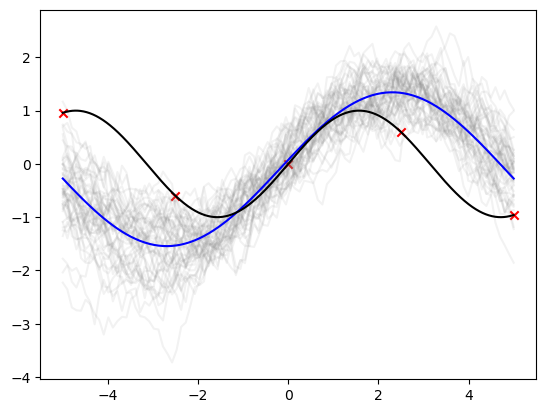

In [429]:
for i in range(50):
    plt.plot(x_test, f_pred.sample(), color = 'grey', label = 'posterior sample', alpha = 0.1)

plt.plot(x_test, f_pred.mean, color = 'blue', label = 'posterior mean')
plt.scatter(x_train, y_train, marker = 'x', color = 'red', label = 'observations')
plt.plot(torch.linspace(-5, 5, 1000), torch.sin(torch.linspace(-5, 5, 1000)), color = 'black', label = 'true function')

In [286]:
import gpytorch

In [ ]:

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)